In [1]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
#import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm


#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import os
import sys
import gc
import joblib

os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
#os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

from celldyn_qc import QcControl
from ctransformers import CellDynTrans

write_to_disk = False
read_from_disk = True

from recombinators import CellDynRecombinator

from umap import UMAP

from numba import njit, float32
from numpy import linalg as la
#import ray
#ray.init()

In [2]:
@njit(float32(float32[:],float32[:]), fastmath=True)
def poincarre_dist(x,y):
    return np.arccosh(\
    1 + 2*(\
        la.norm(x-y,ord = 2)**2/((1-la.norm(x,ord = 2)**2)*(1-la.norm(y,ord = 2)**2))
        )
    )
@njit(float32(float32[:],float32[:], float32), fastmath=True)
def fractional_distance(x, y, f=0.5):
    return np.power(np.abs(np.sum(np.power(x-y, f))), 1/f)

In [3]:
cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_cleaned_transformed_imputed_ALL_with_ratios.feather"
celldyn = pd.read_feather(cpath)
celldyn.columns = celldyn.columns.str.lower()


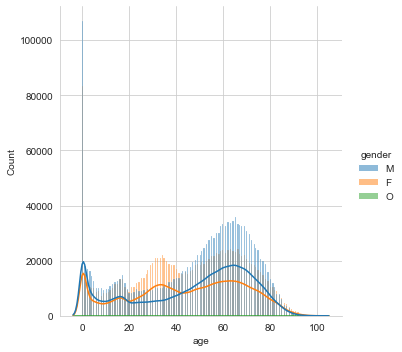

In [4]:
sns.displot(data=celldyn, x='age', hue='gender', kde=True)

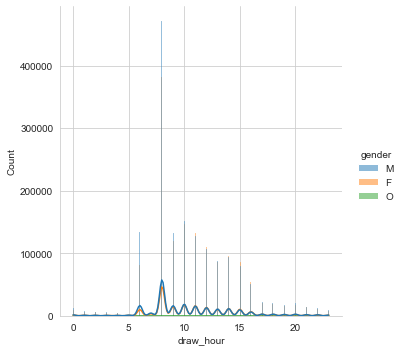

In [5]:
sns.displot(data=celldyn, x='draw_hour', hue='gender', kde=True)

### Patients who have measurements in the evening and during the day

In [6]:
meas_per_patient = celldyn.shape[0]/celldyn.studyid_alle_celldyn.nunique()
print(f"There are on average {meas_per_patient} measurements per patient")

There are on average 8.627080928240392 measurements per patient


In [7]:
counts_per_patient = pd.DataFrame(celldyn.groupby('studyid_alle_celldyn').size(),  
                        columns=['counts_per_patient'])
celldyn = celldyn.merge(counts_per_patient.reset_index(), how='left', on='studyid_alle_celldyn')

In [8]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour']

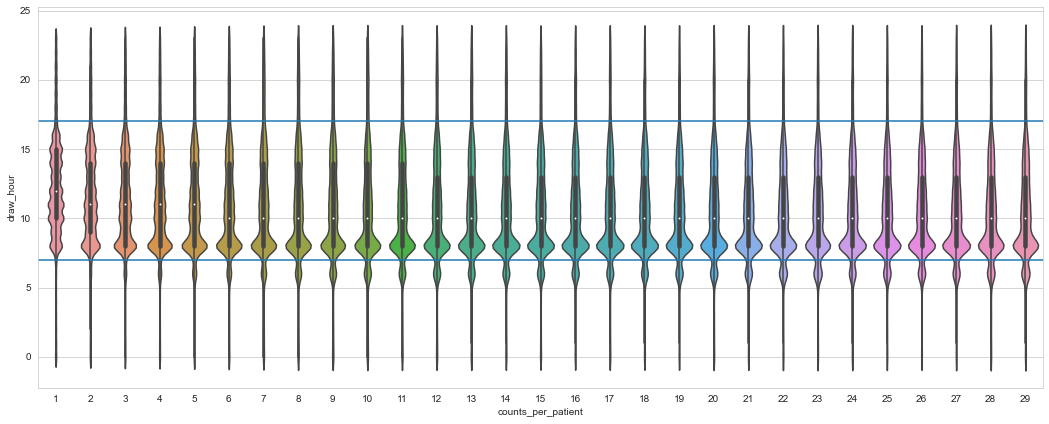

In [9]:
fig, ax = plt.subplots(figsize=(18,7))
sns.violinplot(data=celldyn[celldyn.counts_per_patient<30], x='counts_per_patient', y='draw_hour')
plt.axhline(7)
plt.axhline(17)

There are three blocks: 
* routine block: from 7AM to 5PM, mostly poli perhaps?
* evening block: from 5PM to 12PM
* morning block: from 12PM to 7AM

In [10]:
celldyn.loc[:,'care_block'] = celldyn.apply(lambda x: 'routine_block'\
                                    if (x['draw_hour']>=7) & (x['draw_hour']<17)
                                    else 'evening_block' if (x['draw_hour']>=17) & (x['draw_hour']<=23)
                                    else 'morning_block', axis=1
)
meta_cols.append('care_block')
celldyn = celldyn.assign(draw_minute=celldyn.afname_dt.dt.minute)

In [11]:
celldyn = celldyn.assign(draw_hour_dec=celldyn[['draw_hour', 'draw_minute']].apply(lambda x: round(x[0]+x[1]/60, 2), axis=1))

<AxesSubplot:xlabel='draw_hour_dec', ylabel='c_b_mon'>

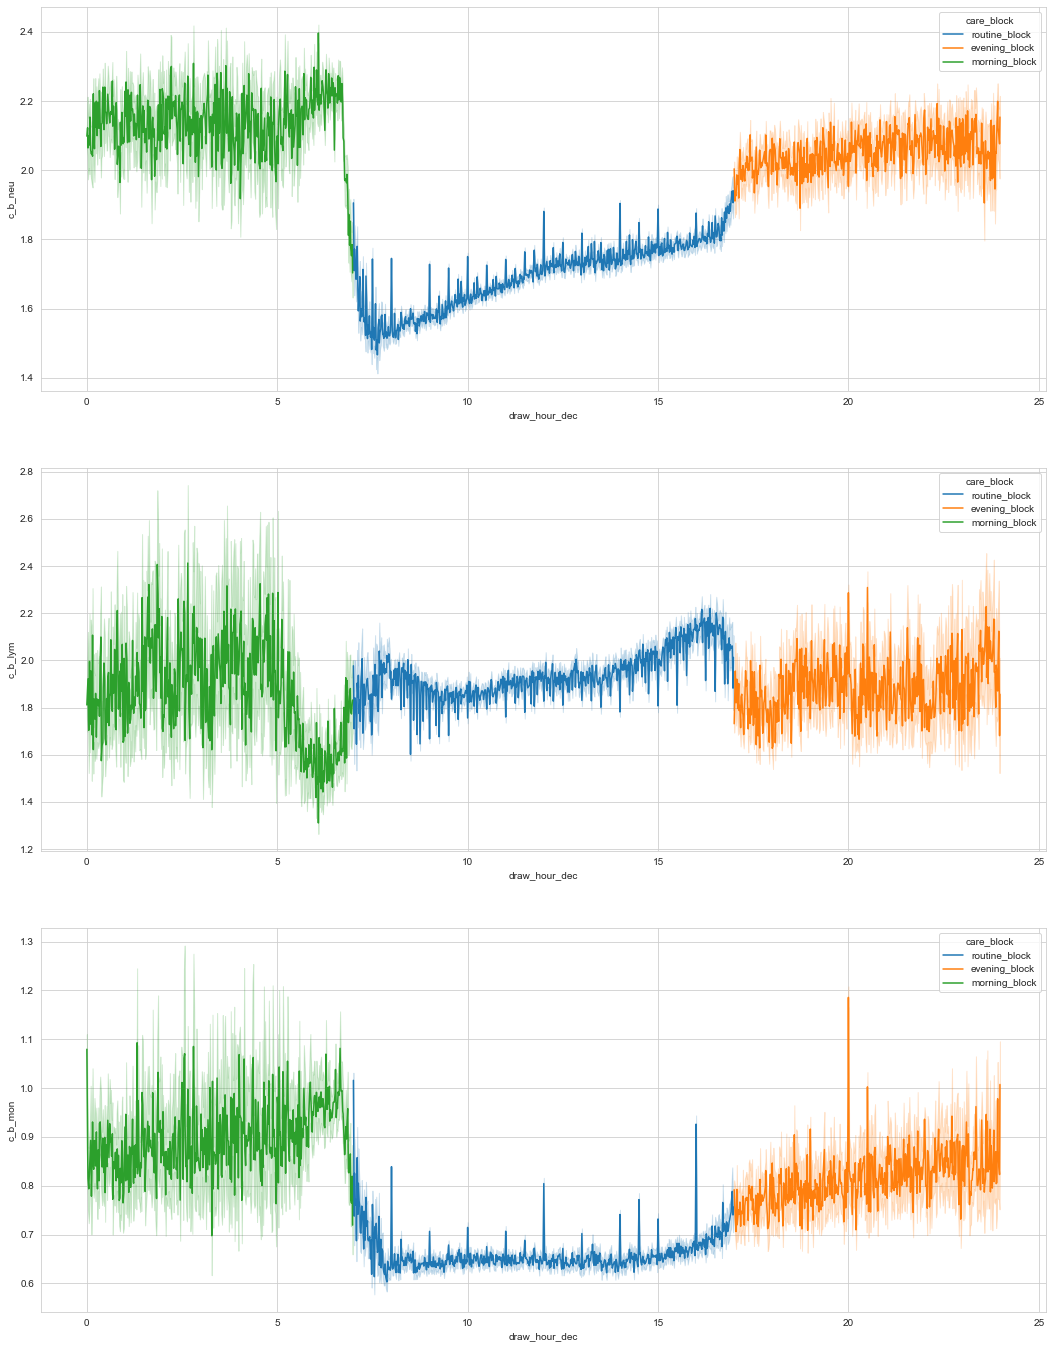

In [12]:
fig, ax = plt.subplots(nrows=3, figsize=(18,24))
sns.lineplot(data=celldyn, x='draw_hour_dec', y='c_b_neu', hue='care_block', ax=ax[0])
sns.lineplot(data=celldyn, x='draw_hour_dec', y='c_b_lym', hue='care_block', ax=ax[1])
sns.lineplot(data=celldyn, x='draw_hour_dec', y='c_b_mon', hue='care_block', ax=ax[2])

In [13]:
# idea: gplearn in combination with unsupervised embedder?
meas_columns = [c for c in celldyn.columns if any(['c_b' in c, 'combo_' in c]) ]+['plt']
reduced_dimensions = 3
emb_cols = [f'dim_{i}' for i in range(reduced_dimensions)]

sample_index = celldyn.sample(250000).index

celldyn_embedded = celldyn.loc[sample_index, meta_cols].copy()
reduce_pipe = Pipeline([
    ('Standard scaling', StandardScaler()),
    ('Embedder', UMAP(n_components=3, n_neighbors=50, n_jobs=8, min_dist=0, metric=poincarre_dist, densmap=False))
])
celldyn_embedded.loc[:, emb_cols] = reduce_pipe.fit_transform(celldyn.loc[sample_index, meas_columns])
celldyn_embedded = celldyn_embedded.assign(normal_prick=celldyn_embedded.draw_hour==8)


d:\VENVS\Envs\hema_embedder\lib\site-packages\umap\umap_.py:1727: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


In [14]:
import plotly.express as px

In [19]:
fig = px.scatter_3d(celldyn_embedded.sample(10000), x='dim_0', y='dim_1', z='dim_2',
                    color='age', size_max=18, opacity=0.25)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))